In [1]:
%matplotlib inline


# Classification of text documents using sparse features

This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be
automatically downloaded, then cached.


In [2]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

## Configuration options for the analysis



In [3]:
# If True, we use `HashingVectorizer`, otherwise we use a `TfidfVectorizer`
USE_HASHING = False

# Number of features used by `HashingVectorizer`
N_FEATURES = 2**16

# Optional feature selection: either False, or an integer: the number of
# features to select
SELECT_CHI2 = False

## Load data from the training set
Let's load data from the newsgroups dataset which comprises around 18000
newsgroups posts on 20 topics split in two subsets: one for training (or
development) and the other one for testing (or for performance evaluation).



In [4]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

data_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42
)
print("data loaded")

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print(
    "%d documents - %0.3fMB (training set)" % (len(data_train.data), data_train_size_mb)
)
print("%d documents - %0.3fMB (test set)" % (len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))

data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories


## Vectorize the training and test data

split a training set and a test set



In [5]:
y_train, y_test = data_train.target, data_test.target

Extracting features from the training data using a sparse vectorizer



In [6]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

t0 = time()

if USE_HASHING:
    vectorizer = HashingVectorizer(
        stop_words="english", alternate_sign=False, n_features=N_FEATURES
    )
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)

done in 0.385731s at 10.317MB/s
n_samples: 2034, n_features: 33809


Extracting features from the test data using the same vectorizer



In [7]:
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)

done in 0.245660s at 11.673MB/s
n_samples: 1353, n_features: 33809


mapping from integer feature name to original token string



In [8]:
if USE_HASHING:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names_out()

Keeping only the best features



In [9]:
from sklearn.feature_selection import SelectKBest, chi2

if SELECT_CHI2:
    print("Extracting %d best features by a chi-squared test" % SELECT_CHI2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=SELECT_CHI2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names is not None:
        # keep selected feature names
        feature_names = feature_names[ch2.get_support()]
    print("done in %fs" % (time() - t0))
    print()

## Benchmark classifiers

First we define small benchmarking utilities



In [10]:
import numpy as np
from sklearn import metrics
from sklearn.utils.extmath import density


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, "coef_"):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time

We now train and test the datasets with 15 different classification
models and get performance results for each model.



In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"))
)

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    "feature_selection",
                    SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                ),
                ("classification", LinearSVC(penalty="l2")),
            ]
        )
    )
)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.154s
test time:  0.001s
accuracy:   0.897
dimensionality: 33809
density: 0.999941
top 10 keywords per class:
alt.atheism: wingate atheist osrhe god okcforum caltech islamic atheism keith...
comp.graphics: animation video looking card hi 3d thanks file image graphics
sci.space: dc flight shuttle launch pat moon sci orbit nasa space
talk.religion.misc: mitre jesus hudson morality 2000 biblical beast mr fbi ch...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.90      0.98      0.94       389
         sci.space       0.95      0.95      0.95       394
talk.religion.misc       0.83      0.77      0.80       251

          accuracy                           0.90      1353
         macro avg       0.89      0.

/home/transcend/code/BANGKOK/nrich/nrich-test-assignment/venv/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:830: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


accuracy:   0.888
dimensionality: 33809
density: 0.255302
top 10 keywords per class:
alt.atheism: wingate osrhe freedom lippard alt thing cobb atheists atheism keith
comp.graphics: siggraph code fractal comp mpeg library pc animation sphere gr...
sci.space: bruce wpi solar sci funding moon orbit planets dc space
talk.religion.misc: god morality hudson beast sword fbi 2000 order mr christian

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.86      0.80      0.83       319
     comp.graphics       0.90      0.97      0.94       389
         sci.space       0.95      0.93      0.94       394
talk.religion.misc       0.79      0.80      0.79       251

          accuracy                           0.89      1353
         macro avg       0.88      0.88      0.88      1353
      weighted avg       0.89      0.89      0.89      1353

confusion matrix:
[[256   7   8  48]
 [  0 379   4   6]
 [  7  21 366   0]
 [ 33  12   6 200]]

Pas

train time: 0.193s
test time:  0.002s
accuracy:   0.901
dimensionality: 33809
density: 0.185454
top 10 keywords per class:
alt.atheism: rushdie charley cobb atheist caltech wingate islamic keith athei...
comp.graphics: computer 42 points 3do hi 3d file image animation graphics
sci.space: rockets planets shuttle launch dc sci moon nasa orbit space
talk.religion.misc: homosexuality abortion biblical 666 morality mr 2000 fbi ...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.84      0.85       319
     comp.graphics       0.93      0.97      0.95       389
         sci.space       0.94      0.95      0.95       394
talk.religion.misc       0.82      0.78      0.80       251

          accuracy                           0.90      1353
         macro avg       0.89      0.89      0.89      1353
      weighted avg       0.90      0.90      0.90      1353

confusion matrix:
[[268   6   9  36]
 [  0 379   5   5]
 [  2  

## Add plots
The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



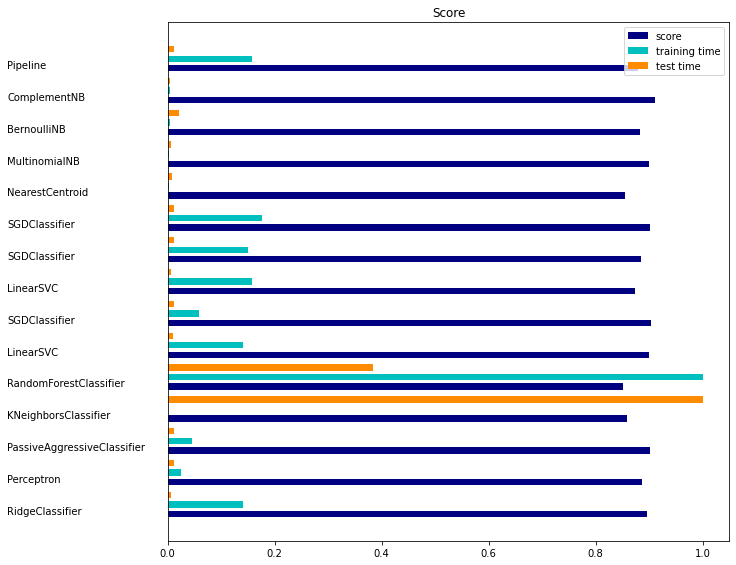

In [12]:
import matplotlib.pyplot as plt

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()